In [1]:
import datetime
import math
from itertools import product
from random import choices, randint
from typing import List, Tuple

import numpy as np
import shapely.affinity as affinity
import shapely.geometry as geo
import vsketch
from sklearn.neighbors import NearestNeighbors


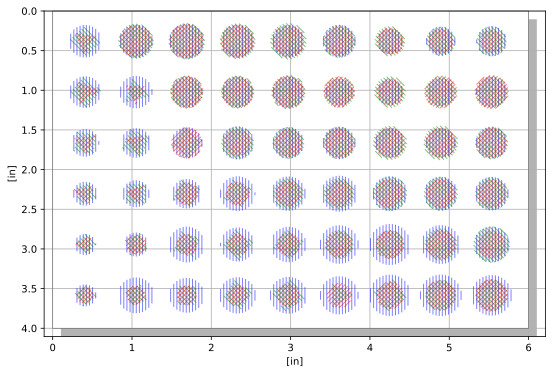

In [2]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

W = vsk.width
H = vsk.height

def circle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 16)


def diamond(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 1)


# https://stackoverflow.com/q/65544295
def triangle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    side_length = radius * math.sqrt(3)
    # Calculate three vertices of the container triangle
    a = [center[0], center[1] + (math.sqrt(3) / 3) * side_length]  # Top vertex
    b = [
        center[0] - (side_length / 2),
        center[1] - (math.sqrt(3) / 6) * side_length,
    ]  # Bottom left vertex
    c = [center[0] + (side_length / 2), center[1] - (math.sqrt(3) / 6) * side_length]
    return geo.Polygon([a, b, c])

shapefuncs = [diamond, circle, triangle]


MARGIN = 25
BORDER = geo.LinearRing(
    [
        (MARGIN, MARGIN),
        (MARGIN, H - MARGIN),
        (W - MARGIN, H - MARGIN),
        (W - MARGIN, MARGIN),
    ]
)
BORDER_POLYGON = geo.Polygon(BORDER)

RADIUS = 30
SPACING = RADIUS * (2 + 0.05)

max_dim = max(vsk.width, vsk.height)

# Backgrounds
vsk.penWidth("0.5mm")
step = vsk.strokePenWidth * 2

vertical_lines = []
diag_right_lines = []
diag_left_lines = []
# Draw vertical lines from the left to the right of the canvacs
for x in np.arange(0, max_dim, step=step):
    vertical_lines.append(geo.LineString([(x, 0), (x, max_dim)]))

diag_right_base = geo.LineString([(0, 0), (max_dim, max_dim)])
diag_right_lines = [diag_right_base]
diag_left_base = geo.LineString([(0, max_dim), (max_dim, 0)])
diag_left_lines = [diag_left_base]

for r in np.arange(0, max_dim, step=step):
    diag_right_lines.append(
        affinity.translate(diag_right_base, r * math.sqrt(step / 2), 0)
    )
    diag_right_lines.append(
        affinity.translate(diag_right_base, 0, r * math.sqrt(step / 2))
    )
    diag_left_lines.append(
        affinity.translate(diag_left_base, -r * math.sqrt(step / 2), 0)
    )
    diag_left_lines.append(
        affinity.translate(diag_left_base, 0, r * math.sqrt(step / 2))
    ) 

layer_lines = [vertical_lines, diag_right_lines, diag_left_lines]
# Creates grid of points from Start Margin to End Margin
# with each point `SPACING` apart
xrange = np.arange(MARGIN, int(W - MARGIN), SPACING)
yrange = np.arange(MARGIN, int(H - MARGIN), SPACING)
xyrange = (xrange, yrange)
points = []
for x in xrange:
    for y in yrange:
        points.append((x, y))


def knn_grid(
    grid_points: List[Tuple[float, float]], k: int = 3, metric: str = "euclidean"
) -> List[int]:
    """
    Among a grid, randomly select 3 centroids and return a list of len(grid_points)
    with the ID of the closest centroid
    """
    centers = choices(grid_points, k=k)  # choose k points to be "centers"
    neigh = NearestNeighbors(n_neighbors=1, metric=metric)
    neigh.fit(centers)  # fit knn on those centers as the 'label'
    # for each point, return the 1st nearest neighbor
    closest_point = neigh.kneighbors(points, 1, return_distance=False)
    labels = list(c[0] for c in closest_point)
    return labels


def generate_layer_shapes(
    grid_points: List[Tuple[float, float]], labels: List[int]
) -> List[geo.Polygon]:
    n_unique_labels = len(set(labels))
    # Assign each neighborhood a shape
    label_shape_functions = {
        l: np.random.choice(shapefuncs) for l in range(n_unique_labels)
    }
    # add some arbitrary value for the noise 3rd dimension
    label_noise_start = {l: randint(0, 100) for l in range(n_unique_labels)}
    layer_shapes = []
    for (x, y), l in zip(grid_points, labels):
        vsk.stroke(l + 1)
        xn = x / (W - MARGIN)
        yn = y / (H - MARGIN)
        sfunc = label_shape_functions[l]
        shape = sfunc((x, y), RADIUS)
        noise = vsk.noise(xn, yn, label_noise_start[l])
        rotatenoise = np.interp(noise, [0, 1], [0, 359])
        scalenoise = np.interp(noise, [0, 1], [0.2, 1.1])
        shape = affinity.scale(shape, scalenoise, scalenoise, origin="centroid")
        shape = affinity.rotate(shape, rotatenoise, origin="centroid")
        layer_shapes.append(shape)
    return layer_shapes


l1_shapes = generate_layer_shapes(points, knn_grid(points, k=2))
l2_shapes = generate_layer_shapes(points, knn_grid(points, metric="cosine"))
l3_shapes = generate_layer_shapes(points, knn_grid(points))

vertical_lines_geo = geo.MultiLineString(vertical_lines)
diag_right_lines_geo = geo.MultiLineString(diag_right_lines)
diag_left_lines_geo = geo.MultiLineString(diag_left_lines)

def fill_layer_shapes(shapes: List[geo.Polygon], fill_lines: geo.MultiPolygon) -> List[geo.MultiLineString]:
    filled_shapes = []
    for shape in shapes:
        shape_filled = shape.intersection(fill_lines)
        filled_shapes.append(shape_filled)
    return filled_shapes

vsk.stroke(1)
for shape in fill_layer_shapes(l1_shapes, vertical_lines_geo):
    vsk.geometry(shape)
vsk.stroke(2)
for shape in fill_layer_shapes(l2_shapes, diag_right_lines_geo):
    vsk.geometry(shape)
vsk.stroke(3)
for shape in fill_layer_shapes(l3_shapes, diag_left_lines_geo):
    vsk.geometry(shape)

vsk.display(mode="matplotlib", fig_size=(6 * 1.5, 4 * 1.5), unit="in", grid=True)


In [3]:
vsk.vpype("linesimplify linemerge reloop linesort")
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")
vsk.save(f"knn-shapes-{timestamp}.svg")